In [1]:
from os import removedirs

import numpy as np
import pandas as pd
from fontTools.subset import remap
from sentence_transformers.util import cos_sim
from sentence_transformers import SentenceTransformer
import seaborn as sns
import matplotlib.pyplot as plt
import ast
from collections import defaultdict

from sklearn.cluster import HDBSCAN
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import silhouette_score
from sklearn.metrics import silhouette_samples
import umap.umap_ as umap

/Users/ethan/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/ethan/Library/Python/3.9/lib/python/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Import
1. Pull in the 3 models outputs.
    - Remove any rows that have Na in the answer somehow
2. Join the split questions together
3. Convert Json to a dictionary to be processed
4. Cut the empty codes
5. bring in the id info
    - clean it to match

In [2]:
l_df = pd.read_csv('../LLM_Run/good/llama70b.csv').dropna(subset=['answer'], how='any')
g_df = pd.read_csv('../LLM_Run/good/gemma3_27b.csv').dropna(subset=['answer'], how='any')
q_df = pd.read_csv('../LLM_Run/good/Qwen32b.csv').dropna(subset=['answer'], how='any')

In [3]:
def join_Dfs(df):
    df['id'] = df['id'].apply(lambda x: x.split('-')[0])
    df_grouped = df.groupby(['id', 'prompt']).agg({
        'json': lambda x: '[' + ', '.join(x.str.strip('[]')) + ']',
        **{col: 'first' for col in df.columns if col not in ['id', 'prompt', 'json']}
    }).reset_index()
    return df_grouped

joined_df = pd.concat([l_df, g_df, q_df])
df = join_Dfs(joined_df)

### Join split questions
These were questions that were too big to be processed, split up. Split questions were marked with a suffix on the column 'id' that looked like '-1', indicating what part of the question it was.

In [4]:
def join_Split_Questions(df):
    df['id'] = df['id'].apply(lambda x: x.split('-')[0])
    df_grouped = df.groupby(['id', 'prompt']).agg({
        'json': lambda x: '[' + ', '.join(x.str.strip('[]')) + ']',
        'answer': lambda x: ''.join(x),
        **{col: 'first' for col in df.columns if col not in ['id', 'prompt', 'json', 'answer']}
    }).reset_index()
    return df_grouped

df = join_Split_Questions(df)

### Convert to dictionary

In [5]:
def convert_to_dict(x):
    try:
        # Try to safely evaluate the string as a Python dictionary
        output = ast.literal_eval(x)

        return output
    except (ValueError, SyntaxError) as e:
        # Print the exception for debugging
        print(f"Didn't work: {x}")
        print(f"Exception: {e}")
        return None

df['json'] = df['json'].apply(convert_to_dict)

### Cut empty codes
Cut codes that are empty/meaningless. This list can be expanded, but for now i'm cutting 'I don't know' and affirmations

In [6]:
model_ckpt = 'sentence-transformers/distiluse-base-multilingual-cased-v2'
sim_model = SentenceTransformer(model_ckpt)

def similarity_Scores(s1, to_compare):
    embeddings = np.concatenate([[s1], to_compare])
    sim = np.zeros((len(embeddings), len(embeddings)))
    sim[0] = cos_sim(embeddings[0], embeddings[0:])
    return sim[0][1:]

def cut_Empty(model, json_list):
    to_drop = set()
    rem_words = model.encode(['Yeah', 'Agreed', 'No Code', "I don't know", 'Right'])
    for i in range(len(json_list)):
        c_emb = model.encode(json_list[i]['Code'])
        # Drop if answer or topic too close to an affirmation
        # This uses the agreement threshold determined by the previous analysis
        if max(similarity_Scores(c_emb, rem_words)) > .5:
            print(json_list[i]['Code'], similarity_Scores(c_emb, rem_words))
            to_drop.add(i)

    json_list = [item for idx, item in enumerate(json_list) if idx not in to_drop]

    return json_list


# Apply the function to each row in the 'json_list' column
df['json'] = df['json'].apply(lambda x: cut_Empty(sim_model, x))

 [0.68541801 0.50709397 0.39763692 0.43167564 0.61074877]
No Response [0.26848853 0.20628816 0.51028287 0.31961626 0.23232396]
Straightforward [0.38926756 0.36146632 0.27306157 0.21049398 0.60560846]
Not Universal [0.2806831  0.23542236 0.50989455 0.31204033 0.26089767]
No Response [0.26848853 0.20628816 0.51028287 0.31961626 0.23232396]
No Response [0.26848853 0.20628816 0.51028287 0.31961626 0.23232396]
No Response [0.26848853 0.20628816 0.51028287 0.31961626 0.23232396]


### Build a column that has all the codes extracted

In [7]:
def extract_Codes(json_list):
    return [entry['Code'] for entry in json_list]

df['code_list'] = df['json'].apply(extract_Codes)

### Id info
Bringing in the id info, cleaning it and joining it to the df

In [8]:
id_info = pd.read_csv('../sensitive/id_info.csv')
q3_mapping = {
    'Obesity': 'Obesity',
    'obesity': 'Obesity',
    'Obesity/Overweight': 'Obesity',
    'Obesity and Overweight': 'Obesity',
    'overweight and obesity': 'Obesity',
    'Obesity/overweight': 'Obesity',
    'Obesity and overweight': 'Obesity',
    'Overweight/Obesity': 'Obesity',
    'overweight/obesity': 'Obesity',
    'Obestiy': 'Obesity',
    'Obesity ': 'Obesity',
    'Depression ': 'Depression'
}
id_info['Q3_Health Problem'] = id_info['Q3_Health Problem'].replace(q3_mapping)
id_info['Q3_Health Problem'].value_counts()

Q3_Health Problem
Obesity       43
Depression    18
Name: count, dtype: int64

In [9]:
def merge_Id_df(df):
    df['id_l'] = df['id']
    df['id'] = df['id'].str[:-4]
    return pd.merge(df, id_info, on='id', how='left')

df = merge_Id_df(df)

In [10]:
df

,id,prompt,json,answer,code_list,id_l,Q2_Utah Small Area,Q3_Health Problem,Q5_Sex,Q6_Race/Ethnicity - Selected Choice,Q7_Age Group,Q8_Affiliation
0,0_PAY_M,Q10_Health Impact,[{'Original_Text': 'Impacts some of our poores...,Impacts some of our poorest residents harder. ...,"[Disproportionate Impact, Socio-Economic Dispa...",0_PAY_M_Q10,Payson,Obesity,Male,White/Caucasian,45-54,"Resident, Operations Manager for Family Search"
1,0_PAY_M,Q11_At-Risk Populations,"[{'Original_Text': 'Black Women', 'Code': 'Spe...",Black Women,"[Specific Demographic Group, Specific At-Risk ...",0_PAY_M_Q11,Payson,Obesity,Male,White/Caucasian,45-54,"Resident, Operations Manager for Family Search"
2,0_PAY_M,Q12_Risk Factors,"[{'Original_Text': 'Childhood trauma', 'Code':...","Childhood trauma, getting food that is addicti...","[Adverse Childhood Experiences, Unhealthy Food...",0_PAY_M_Q12,Payson,Obesity,Male,White/Caucasian,45-54,"Resident, Operations Manager for Family Search"
3,0_PAY_M,Q13_Root Cause,[{'Original_Text': 'Most people struggle to kn...,Most people struggle to know what foods are be...,"[Lack of Nutrition Knowledge, Genetic Influenc...",0_PAY_M_Q13,Payson,Obesity,Male,White/Caucasian,45-54,"Resident, Operations Manager for Family Search"
4,0_PAY_M,Q14_Community Strengths,"[{'Original_Text': 'Good friends', 'Code': 'So...","Good friends, finances, outdoor community/comm...","[Social Support Network, Economic Stability, O...",0_PAY_M_Q14,Payson,Obesity,Male,White/Caucasian,45-54,"Resident, Operations Manager for Family Search"
...,...,...,...,...,...,...,...,...,...,...,...,...
471,9_PRO_M,Q13_Root Cause,"[{'Original_Text': 'Okay, this is easier for p...","Okay, this is easier for people to get food. E...","[Convenience, Cost-Effective, Affordability, T...",9_PRO_M_Q13,Provo West City Center,Obesity,Male,Asian or Asian American,35-44,Asian Market employee
472,9_PRO_M,Q14_Community Strengths,"[{'Original_Text': 'we can have more events.',...","Okay, you know, we can have more events.\nkind...","[Desire for More Community Events, Marathon Ev...",9_PRO_M_Q14,Provo West City Center,Obesity,Male,Asian or Asian American,35-44,Asian Market employee
473,9_PRO_M,Q15_Resources,[{'Original_Text': 'Probably have more young p...,Probably have more young people because of the...,"[Demographic Influence, Observation of Active ...",9_PRO_M_Q15,Provo West City Center,Obesity,Male,Asian or Asian American,35-44,Asian Market employee
474,9_PRO_M,Q16_Solutions,"[{'Original_Text': 'After 40, if you have the ...","I know I'm almost 40. After 40, if you have th...","[Age-Based Health Screening, Reducing Age Thre...",9_PRO_M_Q16,Provo West City Center,Obesity,Male,Asian or Asian American,35-44,Asian Market employee


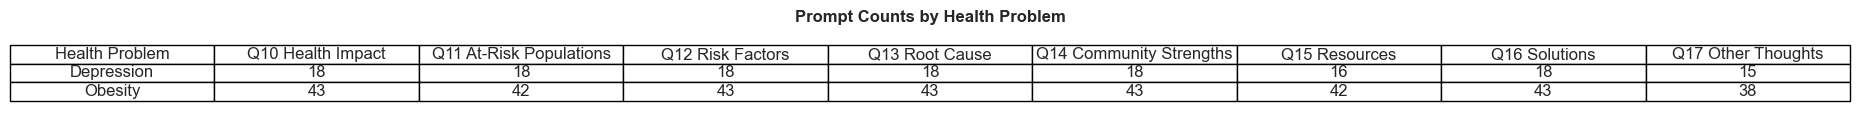

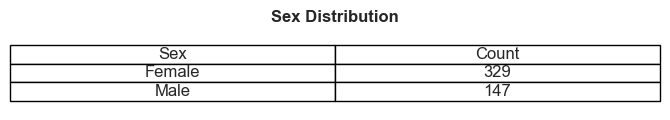

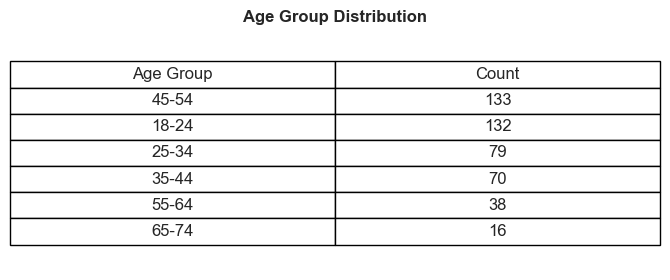

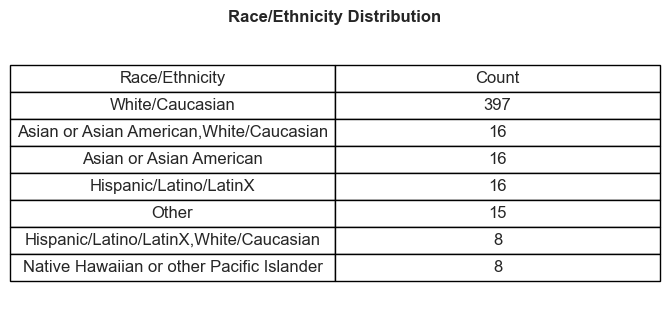

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import re

df2 = df.copy()
df2.rename(columns={'Q6_Race/Ethnicity - Selected Choice': 'Race/Ethnicity'}, inplace=True)

# --- Clean column names (remove Q#_ prefix) ---
df2.columns = [re.sub(r'^Q\d+_', '', col) for col in df2.columns]
df2['prompt'] = df2['prompt'].apply(lambda x: re.sub(r'^(Q\d+)_', r'\1 ', x))

# --- Prompt counts per Health Problem ---
prompt_counts = df2.groupby('Health Problem')['prompt'].value_counts().unstack().fillna(0).astype(int)

# --- Demographic counts ---
sex_counts = df2['Sex'].value_counts()
race_counts = df2['Race/Ethnicity'].value_counts()
age_counts = df2['Age Group'].value_counts()

# Combine into separate DataFrames
sex_df = sex_counts.reset_index().rename(columns={'index': 'Sex', 'count': 'Count'})
race_df = race_counts.reset_index().rename(columns={'index': 'Race/Ethnicity', 'count': 'Count'})
age_df = age_counts.reset_index().rename(columns={'index': 'Age Group', 'count': 'Count'})

# --- Function to plot a table ---
def plot_table(dataframe, title):
    fig, ax = plt.subplots(figsize=((len(dataframe.columns)+2) * 1.7, .5 + len(dataframe) * .4))
    ax.axis('off')
    table = ax.table(cellText=dataframe.values,
                     colLabels=dataframe.columns,
                     cellLoc='center',
                     loc='center')
    table.auto_set_font_size(False)
    table.set_fontsize(12)
    table.scale(1, 1.5)
    ax.set_title(title, fontweight="bold", pad=10)
    plt.tight_layout()
    plt.show()

# --- Plot all tables ---
plot_table(prompt_counts.reset_index(), "Prompt Counts by Health Problem")
plot_table(sex_df, "Sex Distribution")
plot_table(age_df, "Age Group Distribution")
plot_table(race_df, "Race/Ethnicity Distribution")

### Build a master map, of codes to their original text. Allows for later reconnecting of codes to their original authors

In [12]:
def build_Map_DF(df):
    df_exploded = df.explode('json')
    df_exploded['Code'] = df_exploded['json'].apply(lambda x: x.get('Code') if isinstance(x, dict) else None)
    df_exploded['og_text']= df_exploded['json'].apply(lambda x: x.get('Original_Text') if isinstance(x, dict) else None)
    df_exploded = df_exploded.dropna(subset=['Code'])

    id_df = df_exploded.groupby(['prompt', 'Q3_Health Problem']).apply(
        lambda g: g.groupby('Code')['id'].apply(list).to_dict()
    ).reset_index(name='Code_Id_Map')

    txt_df = df_exploded.groupby(['prompt', 'Q3_Health Problem'], group_keys=False).apply(
        lambda g: g[['Code', 'og_text']].groupby('Code')['og_text'].apply(list).to_dict()
    ).reset_index(name='Code_Text_Map')

    map_df = pd.merge(txt_df, id_df, on=['prompt','Q3_Health Problem'])

    return map_df

map_df = build_Map_DF(df)

/var/folders/fk/rsz_slmj7wj_dw8gjqj0qvsc0000gn/T/ipykernel_40825/3044733151.py:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  id_df = df_exploded.groupby(['prompt', 'Q3_Health Problem']).apply(
/var/folders/fk/rsz_slmj7wj_dw8gjqj0qvsc0000gn/T/ipykernel_40825/3044733151.py:11: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  txt_df = df_exploded.groupby(['prompt', 'Q3_Health Problem'], group_keys=False).apply

# Clustering
0. Extract the codes for each topic-prompt combination
1. Test Kmeans
2. Test HDB Scan
3. Find best hyper-parameters for HDB scan

In [13]:
def extract_codes_by_prompt(df):
    grouped = df.groupby(['prompt', 'Q3_Health Problem'])['json'].apply(
        lambda json_lists: [entry['Code'] for json_list in json_lists for entry in json_list]
    )
    return grouped

all_codes = extract_codes_by_prompt(df).reset_index()

In [14]:
all_codes

,prompt,Q3_Health Problem,json
0,Q10_Health Impact,Depression,"[Prevalence of Depression, Personal Therapy Ex..."
1,Q10_Health Impact,Obesity,"[Disproportionate Impact, Socio-Economic Dispa..."
2,Q11_At-Risk Populations,Depression,"[Teens at Risk, Loneliness and Isolation, Gend..."
3,Q11_At-Risk Populations,Obesity,"[Specific Demographic Group, Specific At-Risk ..."
4,Q12_Risk Factors,Depression,"[Social Media, Emotional Isolation, Geographic..."
5,Q12_Risk Factors,Obesity,"[Adverse Childhood Experiences, Unhealthy Food..."
6,Q13_Root Cause,Depression,"[Isolation, Sense of Community, Types of Commu..."
7,Q13_Root Cause,Obesity,"[Lack of Nutrition Knowledge, Genetic Influenc..."
8,Q14_Community Strengths,Depression,"[School-Based Support Initiatives, Support for..."
9,Q14_Community Strengths,Obesity,"[Social Support Network, Economic Stability, O..."


## Kmeans

In [15]:
from sklearn.preprocessing import normalize

class KMeansCosine:
    def __init__(self, n_clusters=3, max_iter=300, tol=1e-4, random_state=None):
        self.n_clusters = n_clusters
        self.max_iter = max_iter
        self.tol = tol
        self.random_state = random_state
        self.centroids = None
        self.labels_ = None
        self.centers = None

    def _cosine_similarity(self, X, Y):
        # Cosine similarity = dot product of normalized vectors
        return np.dot(X, Y.T)

    def _initialize_centroids(self, X):
        if self.random_state:
            np.random.seed(self.random_state)
        random_idxs = np.random.permutation(X.shape[0])
        centroids = X[random_idxs[:self.n_clusters]]
        return centroids

    def fit(self, X):
        self.centroids = self._initialize_centroids(X)

        for _ in range(self.max_iter):
            # Compute similarity between all points and centroids
            similarity = self._cosine_similarity(X, self.centroids)
            self.labels_ = np.argmax(similarity, axis=1)

            new_centroids = np.array([
                X[self.labels_ == i].mean(axis=0)
                for i in range(self.n_clusters)
            ])

            # Normalize new centroids
            # new_centroids = normalize(new_centroids)

            if np.all(np.abs(self.centroids - new_centroids) < self.tol):
                break

            self.centroids = new_centroids


        self.centers = np.array([
            np.argmax(self._cosine_similarity(X, centroid))
            for centroid in self.centroids
        ])

    def predict(self, X):
        similarity = self._cosine_similarity(X, self.centroids)
        return np.argmax(similarity, axis=1)

    def fit_predict(self, X):
        self.fit(X)
        return self.labels_


cluster_counts = [2,3,4,5,6,7,8]
all_scores = []
# Kmeans
for num_clusters in cluster_counts:
    sil_scores = []
    for index, row in all_codes.iterrows():
        X = sim_model.encode(row['json'])
        kmeans_cosine = KMeansCosine(n_clusters=num_clusters, random_state=42)
        kmeans_cosine.fit(X)
        labels = kmeans_cosine.labels_
        centers = kmeans_cosine.centers
        kmeans_silhouette = silhouette_score(X, labels)
        sil_scores.append(kmeans_silhouette)

        # ret_arr = [[] for _ in range(num_clusters)]
        # for sect, sent in zip(labels, row['json_list']):
        #     ret_arr[sect].append(sent)
        #
        # for i, sect in enumerate(ret_arr):
        #     new_row = row.copy()  # Copy the original row
        #     new_row['kmeans_clusters'] = sect  # Assign the cluster to the 'clusters' column
        #     new_row['kmeans_cluster_id'] = i  # Add a cluster identifier
        #     new_row['kmeans_center'] = row['json_list'][centers[i]]
        #     new_row['silhouette_avg'] = kmean_silhouette
        #     new_rows.append(new_row)  # Append the new row to the list

    print(num_clusters, np.mean(sil_scores))
    all_scores.append(np.mean(sil_scores))

2 0.051366016
3 0.055394545
4 0.06151182
5 0.06533306
6 0.069219284
7 0.07382855
8 0.07978629


## HDB Clustering

In [16]:
from sklearn.cluster import HDBSCAN
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import silhouette_score
from sklearn.metrics import silhouette_samples
import umap.umap_ as umap

def hdb_clustering(all_codes, n_neighbors = 5, n_components = 20, min_cluster_size = 5, min_sample_size =5):
    umap_model = umap.UMAP(n_neighbors=n_neighbors, n_components=n_components, min_dist=0.0, metric='cosine', random_state=42)
    hdb = HDBSCAN(min_cluster_size=min_cluster_size, min_samples=min_sample_size)

    all_codes['clusters'] = None
    new_rows = []
    silhouette_scores = []

    for index, row in all_codes.iterrows():
        X = sim_model.encode(row['json'])

        try:
            X = umap_model.fit_transform(X)
        except Exception as e:
            return None
        X_norm = normalize(X) # L2 Normalized Euclidean == cosine similarity
        hdb.fit(X_norm)
        hdb_label_ids = set(hdb.labels_)
        hdb_centroids = np.array([
            X[hdb.labels_ == i].mean(axis=0)
            for i in hdb_label_ids
        ])
        hdb_centers = np.array([
            np.argmax(np.dot(X_norm, centroid.T))
            for centroid in hdb_centroids
        ])

        # Silhouette Score
        sample_silhouette_values = silhouette_samples(X_norm, hdb.labels_)

        # Exclude noise points (-1 labels)
        non_noise_mask = hdb.labels_ != -1
        filtered_sample_silhouette_values = sample_silhouette_values[non_noise_mask]
        filtered_labels = hdb.labels_[non_noise_mask]

        # Compute the average silhouette score excluding noise
        silhouette_avg = np.mean(filtered_sample_silhouette_values)
        silhouette_scores.append(silhouette_avg)

        hdb_dict = defaultdict(list)
        for label, sent in zip(hdb.labels_, row['json']):
            hdb_dict[label].append(sent)

        # Create new rows using the dictionary
        for label, cluster_sentences in hdb_dict.items():
            new_row = row.copy()
            new_row['clusters_size'] = len(cluster_sentences)
            new_row['clusters'] = cluster_sentences
            new_row['cluster_id'] = label
            new_row['center'] = row['json'][hdb_centers[label]]
            new_row['silhouette_avg'] = silhouette_avg
            new_row['silhouette'] = sample_silhouette_values[label]
            new_rows.append(new_row)

    clustered_df = pd.DataFrame(new_rows)
    clustered_df.reset_index(drop=True, inplace=True)

    return clustered_df, np.mean(silhouette_scores)

### Hyper-parameter search for best UMAP parameters

In [17]:
# n_neighbors = [5,10,15,25,50]
# n_components = [10,25,50,100]
# min_cluster_sizes = [5,10,15]
# min_sample_sizes = [5,10,15]
# results = []
#
# for n_neighbor in n_neighbors:
#     for n_component in n_components:
#         for min_cluster_size in min_cluster_sizes:
#             for min_sample_size in min_sample_sizes:
#                 print(n_neighbor, n_component, min_cluster_size, min_sample_size)
#                 _, score = hdb_clustering(all_codes, n_neighbor, n_component, min_cluster_size, min_sample_size)
#                 results.append({'n_neighbors': n_neighbor, 'n_components': n_component, 'min_cluster_size': min_cluster_size, 'min_sample_size': min_sample_size, 'silhouette_score': score})
#
# score_df = pd.DataFrame(results)


In [18]:
# score_df

In [19]:
# blah

In [20]:
# score_df

In [21]:
# score_df.to_csv('cluster_scores.csv', index=False)

## Build best model from the previous searching

From the analysis, n_neighbors=5 and n_components=5 is the best. But, in testing, n_components=5 causes too much variation in the results and is highly dependent on the random state. For increased stability, I used the runner_up, n_components = 10

In [22]:
clustered_df, _ = hdb_clustering(all_codes, 5, 25, 10, 10)

/Users/ethan/PycharmProjects/axial-coding/.venv/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [23]:
_

0.68661165

## Generate Triangulation Score

In [24]:
def map_texts_to_codes(texts, master_map):
    if texts is None:
        return None
    return [master_map[text] for text in texts if text in master_map]

clustered_mapped_df = clustered_df.merge(map_df, on=['prompt', 'Q3_Health Problem'], how='left')
clustered_mapped_df['cluster_orig_ids'] = clustered_mapped_df.apply(
    lambda x: map_texts_to_codes(x['clusters'], x['Code_Id_Map']), axis=1
)
clustered_mapped_df['cluster_orig_texts'] = clustered_mapped_df.apply(
    lambda x: map_texts_to_codes(x['clusters'], x['Code_Text_Map']), axis=1
)

In [25]:
def DeList(top_list):
    ret = []
    if top_list is None:
        return ret
    for x in top_list:
        ret.extend(x)
    return ret

clustered_mapped_df['cluster_orig_texts'] = clustered_mapped_df.apply(lambda row: DeList(row['cluster_orig_texts']), axis=1)
clustered_mapped_df['cluster_orig_ids'] = clustered_mapped_df.apply(lambda row: DeList(row['cluster_orig_ids']), axis=1)
clustered_mapped_df['cluster_orig_ids'] = clustered_mapped_df.apply(lambda row: list(set(row['cluster_orig_ids'])), axis=1)

In [26]:
base_df = pd.read_csv('../sensitive/health_interviews_proc.csv').dropna(subset=['answer'], how='any')
base_df['id'] = base_df['id'].apply(lambda x: '_'.join(x.split('_')[:-1]))

# Dropping rows that have nothing in them
base_df['answer_len'] = base_df['answer'].apply(lambda x: len(x) if x is not np.nan else 0)
base_df = base_df[base_df['answer_len'] > 10]

base_df = pd.merge(base_df, id_info, how='left', on='id')
total_surveyees = base_df.groupby(['prompt', 'Q3_Health Problem']).size().reset_index(name='surveyed')


In [27]:
df_full = pd.merge(clustered_mapped_df, total_surveyees, how='left', on=['prompt', 'Q3_Health Problem'])
df_full['TriangulationScore'] = df_full.apply(lambda row: len(row['cluster_orig_ids'])/row['surveyed'], axis=1)

In [28]:
df_full

,prompt,Q3_Health Problem,json,clusters,clusters_size,cluster_id,center,silhouette_avg,silhouette,Code_Text_Map,Code_Id_Map,cluster_orig_ids,cluster_orig_texts,surveyed,TriangulationScore
0,Q10_Health Impact,Depression,"[Prevalence of Depression, Personal Therapy Ex...","[Prevalence of Depression, Prevalence of Depre...",62,3,Increasing Prevalence of Depression,0.642591,0.639372,{'Acknowledgement of Mental Health Issues': ['...,{'Acknowledgement of Mental Health Issues': ['...,"[35_AME_F, 57_LEH_F, 59_LEH_M, 21_LEH_F, 58_LE...",[I would say there's a lot of depression going...,18,0.777778
1,Q10_Health Impact,Depression,"[Prevalence of Depression, Personal Therapy Ex...","[Personal Therapy Experience, Perceived Increa...",49,11,Disparity in Attention to Mental Health,0.642591,-0.765255,{'Acknowledgement of Mental Health Issues': ['...,{'Acknowledgement of Mental Health Issues': ['...,"[35_AME_F, 8_AME_F, 59_LEH_M, 21_LEH_F, 60_LEH...",[So I've been doing therapy since 2008 when I ...,18,0.500000
2,Q10_Health Impact,Depression,"[Prevalence of Depression, Personal Therapy Ex...","[Increase in Mental Health Issues, COVID as Co...",77,-1,Work Interfering with Social Life,0.642591,0.606143,{'Acknowledgement of Mental Health Issues': ['...,{'Acknowledgement of Mental Health Issues': ['...,"[35_AME_F, 57_LEH_F, 8_AME_F, 30_LEH_F, 3_SPA_...",[And I would say there's definitely in the las...,18,0.888889
3,Q10_Health Impact,Depression,"[Prevalence of Depression, Personal Therapy Ex...","[Localized Impact, Selective Health Impact, He...",24,9,Difficulty Identifying Impact,0.642591,0.536259,{'Acknowledgement of Mental Health Issues': ['...,{'Acknowledgement of Mental Health Issues': ['...,"[30_LEH_F, 59_LEH_M, 20_LEH_M, 60_LEH_M, 19_SP...","[in the area., It does have an impact on some....",18,0.500000
4,Q10_Health Impact,Depression,"[Prevalence of Depression, Personal Therapy Ex...","[Depression vs Anxiety Visibility, Increased D...",12,4,Age and Depression Rates,0.642591,0.626316,{'Acknowledgement of Mental Health Issues': ['...,{'Acknowledgement of Mental Health Issues': ['...,"[57_LEH_F, 59_LEH_M, 21_LEH_F, 60_LEH_M, 19_SP...",[the people who suffer from depression are les...,18,0.333333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
374,Q17_Other Thoughts,Obesity,"[Close-Knit Community, Rapid Disease Transmiss...","[Collective Benefit, Importance of Park Mainte...",13,0,Social Benefits of Parks,0.676682,0.814628,{'Abundance of Adult Gyms in Chinese Parks': [...,{'Abundance of Adult Gyms in Chinese Parks': [...,"[9_PRO_M, 40_ORE_F, 39_ORE_F, 28_PRO_M]","[I think is good for all of us., I think Orem ...",33,0.121212
375,Q17_Other Thoughts,Obesity,"[Close-Knit Community, Rapid Disease Transmiss...","[Make Better Choices, Food Truck Initiative, H...",14,8,Healthy Food Truck Options,0.676682,0.879009,{'Abundance of Adult Gyms in Chinese Parks': [...,{'Abundance of Adult Gyms in Chinese Parks': [...,"[42_PLE_M, 56_PAY_F, 29_ORE_M, 28_PRO_M]","[let's just make better choices., And then I t...",33,0.121212
376,Q17_Other Thoughts,Obesity,"[Close-Knit Community, Rapid Disease Transmiss...","[Market Demand Concerns, Market Viability Conc...",23,9,Need for Outreach,0.676682,0.574375,{'Abundance of Adult Gyms in Chinese Parks': [...,{'Abundance of Adult Gyms in Chinese Parks': [...,"[38_PLE_M, 29_ORE_M, 56_PAY_F, 51_SPR_F, 41_PR...","[Which maybe the market won’t support it…, Whi...",33,0.212121
377,Q17_Other Thoughts,Obesity,"[Close-Knit Community, Rapid Disease Transmiss...","[Silver Bullet Application, Culturally Inclusi...",13,5,Program Beyond Implementation,0.676682,0.294134,{'Abundance of Adult Gyms in Chinese Parks': [...,{'Abundance of Adult Gyms in Chinese Parks': [...,"[38_PLE_M, 29_ORE_M, 41_PRO_F, 32_PRO_F, 46_PR...","[that’s like the silver bullet application., A...",33,0.151515


In [29]:
df_full['TriangulationScore'].mean()

0.2590338184877703

In [30]:
# Generate an id for future use
def generate_id(q_num, problem, clusterId):
    return f"{q_num[:3].upper()}_{problem[:3]}_{str(clusterId).upper()}"


df_full['id'] = df_full.apply(
    lambda row: generate_id(row['prompt'], row['Q3_Health Problem'], row['cluster_id']), axis=1)

## Generate Axial Codes

In [31]:
import os
def read_system_prompt(file_path):
    if os.path.isfile(file_path):
        with open(file_path, 'r') as file:
            return file.read()
    else:
        return ""

In [32]:
import re
import json
def parse_result(result):
    list_pattern = r'\[\s*{.*?\}\s*]'
    json_list_match = re.search(list_pattern, result, re.DOTALL)

    if json_list_match:
        json_list_text = json_list_match.group()
        # Dealing with nested " breaking the json
        json_list_text = re.sub('"', '\'', json_list_text)
        obj = re.sub(r'\{\'', '{"', json_list_text)
        obj = re.sub(r'\'}', '"}', obj)
        obj = re.sub(r'\':', '":', obj)
        obj = re.sub(r':\s*\'', ': "', obj)
        obj = re.sub(r'\',\s*\'', '", "', obj)
        obj = re.sub(r'\[\'', '["', obj)
        obj = re.sub(r'\'\]', '"]', obj)
        try:
            json_data = json.loads(obj)
            return json_data
        except json.JSONDecodeError as e:
            print(f"JSON decoding error: {e}")
            return None
        except Exception as e:
            print(f"Unexpected error: {e}")
            return None
    return None

In [33]:
from itertools import islice

def batch_iterator(iterator, batch_size):
    iterator = iter(iterator)
    while True:
        batch = tuple(islice(iterator, batch_size))
        if not batch:
            return
        yield batch

In [34]:
import requests
url = "http://localhost:11434/api/chat"

def llama3(prompt):
    data = {
        "model": "llama3:70b",
        # "model": "qwen2.5-coder:32b",
        # "model": "gemma3:27b",
        "messages": [
            {
                "role": "user",
                "content": prompt,
            }
        ],
        "stream": False,
        "options": {
            "temperature": 0.7,
            "top_p": 0.2,
            "num_predict": 1000,
            # "stop":["}"],
        },
    }

    headers = {
        "Content-Type": "application/json"
    }

    response = requests.post(url, headers=headers, json=data)
    # print('r: ', response.json())
    return response.json()["message"]["content"]

def generate_prompt(row, system_prompt):
    user_prompt = f"""Open Codes requiring Axial Codes:
                Input:
                Open Codes: {row['clusters']}
                SentenceBERT center: {row['center']}
                JSON Output:
                """
    return system_prompt + '\n' + user_prompt

In [35]:
df_full

,prompt,Q3_Health Problem,json,clusters,clusters_size,cluster_id,center,silhouette_avg,silhouette,Code_Text_Map,Code_Id_Map,cluster_orig_ids,cluster_orig_texts,surveyed,TriangulationScore,id
0,Q10_Health Impact,Depression,"[Prevalence of Depression, Personal Therapy Ex...","[Prevalence of Depression, Prevalence of Depre...",62,3,Increasing Prevalence of Depression,0.642591,0.639372,{'Acknowledgement of Mental Health Issues': ['...,{'Acknowledgement of Mental Health Issues': ['...,"[35_AME_F, 57_LEH_F, 59_LEH_M, 21_LEH_F, 58_LE...",[I would say there's a lot of depression going...,18,0.777778,Q10_Dep_3
1,Q10_Health Impact,Depression,"[Prevalence of Depression, Personal Therapy Ex...","[Personal Therapy Experience, Perceived Increa...",49,11,Disparity in Attention to Mental Health,0.642591,-0.765255,{'Acknowledgement of Mental Health Issues': ['...,{'Acknowledgement of Mental Health Issues': ['...,"[35_AME_F, 8_AME_F, 59_LEH_M, 21_LEH_F, 60_LEH...",[So I've been doing therapy since 2008 when I ...,18,0.500000,Q10_Dep_11
2,Q10_Health Impact,Depression,"[Prevalence of Depression, Personal Therapy Ex...","[Increase in Mental Health Issues, COVID as Co...",77,-1,Work Interfering with Social Life,0.642591,0.606143,{'Acknowledgement of Mental Health Issues': ['...,{'Acknowledgement of Mental Health Issues': ['...,"[35_AME_F, 57_LEH_F, 8_AME_F, 30_LEH_F, 3_SPA_...",[And I would say there's definitely in the las...,18,0.888889,Q10_Dep_-1
3,Q10_Health Impact,Depression,"[Prevalence of Depression, Personal Therapy Ex...","[Localized Impact, Selective Health Impact, He...",24,9,Difficulty Identifying Impact,0.642591,0.536259,{'Acknowledgement of Mental Health Issues': ['...,{'Acknowledgement of Mental Health Issues': ['...,"[30_LEH_F, 59_LEH_M, 20_LEH_M, 60_LEH_M, 19_SP...","[in the area., It does have an impact on some....",18,0.500000,Q10_Dep_9
4,Q10_Health Impact,Depression,"[Prevalence of Depression, Personal Therapy Ex...","[Depression vs Anxiety Visibility, Increased D...",12,4,Age and Depression Rates,0.642591,0.626316,{'Acknowledgement of Mental Health Issues': ['...,{'Acknowledgement of Mental Health Issues': ['...,"[57_LEH_F, 59_LEH_M, 21_LEH_F, 60_LEH_M, 19_SP...",[the people who suffer from depression are les...,18,0.333333,Q10_Dep_4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
374,Q17_Other Thoughts,Obesity,"[Close-Knit Community, Rapid Disease Transmiss...","[Collective Benefit, Importance of Park Mainte...",13,0,Social Benefits of Parks,0.676682,0.814628,{'Abundance of Adult Gyms in Chinese Parks': [...,{'Abundance of Adult Gyms in Chinese Parks': [...,"[9_PRO_M, 40_ORE_F, 39_ORE_F, 28_PRO_M]","[I think is good for all of us., I think Orem ...",33,0.121212,Q17_Obe_0
375,Q17_Other Thoughts,Obesity,"[Close-Knit Community, Rapid Disease Transmiss...","[Make Better Choices, Food Truck Initiative, H...",14,8,Healthy Food Truck Options,0.676682,0.879009,{'Abundance of Adult Gyms in Chinese Parks': [...,{'Abundance of Adult Gyms in Chinese Parks': [...,"[42_PLE_M, 56_PAY_F, 29_ORE_M, 28_PRO_M]","[let's just make better choices., And then I t...",33,0.121212,Q17_Obe_8
376,Q17_Other Thoughts,Obesity,"[Close-Knit Community, Rapid Disease Transmiss...","[Market Demand Concerns, Market Viability Conc...",23,9,Need for Outreach,0.676682,0.574375,{'Abundance of Adult Gyms in Chinese Parks': [...,{'Abundance of Adult Gyms in Chinese Parks': [...,"[38_PLE_M, 29_ORE_M, 56_PAY_F, 51_SPR_F, 41_PR...","[Which maybe the market won’t support it…, Whi...",33,0.212121,Q17_Obe_9
377,Q17_Other Thoughts,Obesity,"[Close-Knit Community, Rapid Disease Transmiss...","[Silver Bullet Application, Culturally Inclusi...",13,5,Program Beyond Implementation,0.676682,0.294134,{'Abundance of Adult Gyms in Chinese Parks': [...,{'Abundance of Adult Gyms in Chinese Parks': [...,"[38_PLE_M, 29_ORE_M, 41_PRO_F, 32_PRO_F, 46_PR...","[that’s like the silver bullet application., A...",33,0.151515,Q17_Obe_5


In [36]:
def run_llm(df, batch_size = 10):
    prompt_file = 'axial_prompt.txt'
    system_prompt = read_system_prompt(prompt_file)
    output_csv_path = 'output_axials/Good_gemma3_1.csv'
    bad_csv_path = 'output_axials/Bad_gemma3_1.csv'

    if os.path.exists(output_csv_path):
        comp_df = pd.read_csv(output_csv_path)
        df = df[~df['id'].isin(set(comp_df['id']))]

    if os.path.exists(bad_csv_path):
        comp_df = pd.read_csv(bad_csv_path)
        df = df[~df['id'].isin(set(comp_df['id']))]

    i = 0
    tot = len(df) // batch_size
    for batch in batch_iterator(df.iterrows(), batch_size):
        i += 1
        if i % 4 == 0:
            print(f"{i} : {tot}")

        batch_prompts = []
        batch_metadata = []
        results = []
        for index, row in batch:
            full_prompt = generate_prompt(row, system_prompt)
            batch_prompts.append(full_prompt)
            this_metadata = {'id': row['id'], 'prompt': row['prompt'], 'model': 'Gemma'}
            batch_metadata.append(this_metadata)
            res = llama3(full_prompt)
            results.append(res)

        new_rows = []
        bad_rows = []
        for metadata, result in zip(batch_metadata, results):
            # print(result)
            if result is not None:
                # print(result)
                parsed_json = parse_result(result)
                if parsed_json is not None:
                    metadata['json'] = parsed_json
                    new_rows.append(metadata)
                else:
                    # print("couldn't parse this: ", metadata[language_in])
                    metadata['result'] = result
                    bad_rows.append(metadata)

        if new_rows:
            print(f"Writing {len(new_rows)} rows to csv")
            # print(f"New ids completed: {[row['id'] for row in new_rows]}")
            new_df = pd.DataFrame(new_rows)
            if os.path.exists(output_csv_path):
                new_df.to_csv(output_csv_path, mode='a', header=False, index=False)
            else:
                new_df.to_csv(output_csv_path, index=False)

        if bad_rows:
            bad_df = pd.DataFrame(bad_rows)
            if os.path.exists(bad_csv_path):
                bad_df.to_csv(bad_csv_path, mode='a', header=False, index=False)
            else:
                bad_df.to_csv(bad_csv_path, index=False)

# run_llm(df_full)

In [37]:
df_axial = pd.read_csv('output_axials/Bad_gemma3_1.csv')
df_axial.drop_duplicates(subset='id', keep='first', inplace=True)
df_axial['result'] = df_axial['result'].apply(lambda x: str(x).split('}')[0] + '}')
df_axial['Axial_Code'] = df_axial['result'].apply(lambda x: ast.literal_eval(x.strip("`json"))['Axial_Category'])
df_axial = df_axial.drop(['result', 'prompt'], axis=1)

In [38]:
df_axial

,id,model,Axial_Code
0,Q10_Dep_3,Gemma,Confronting the Reality of Depression
1,Q10_Dep_11,Gemma,Grasping the Complexity of Mental Health Issues
2,Q10_Dep_-1,Gemma,Navigating the Complexity of Adolescent Mental...
3,Q10_Dep_9,Gemma,Struggling to Articulate the Health Impact
4,Q10_Dep_4,Gemma,Unpacking the Complexities of Mental Health
...,...,...,...
485,Q16_Dep_12,Gemma,Navigating Barriers to Mental Healthcare
486,Q16_Dep_14,Gemma,Recognizing and Framing the Local Problem
487,Q16_Dep_17,Gemma,Struggling to Define and Implement Effective S...
488,Q16_Dep_0,Gemma,Emphasizing Education as a Panacea for Family ...


### Rejoin with previous

In [39]:
df_full_axial = pd.merge(df_full, df_axial, how='left', on='id')
df_full_axial.head()

,prompt,Q3_Health Problem,json,clusters,clusters_size,cluster_id,center,silhouette_avg,silhouette,Code_Text_Map,Code_Id_Map,cluster_orig_ids,cluster_orig_texts,surveyed,TriangulationScore,id,model,Axial_Code
0,Q10_Health Impact,Depression,"[Prevalence of Depression, Personal Therapy Ex...","[Prevalence of Depression, Prevalence of Depre...",62,3,Increasing Prevalence of Depression,0.642591,0.639372,{'Acknowledgement of Mental Health Issues': ['...,{'Acknowledgement of Mental Health Issues': ['...,"[35_AME_F, 57_LEH_F, 59_LEH_M, 21_LEH_F, 58_LE...",[I would say there's a lot of depression going...,18,0.777778,Q10_Dep_3,Gemma,Confronting the Reality of Depression
1,Q10_Health Impact,Depression,"[Prevalence of Depression, Personal Therapy Ex...","[Personal Therapy Experience, Perceived Increa...",49,11,Disparity in Attention to Mental Health,0.642591,-0.765255,{'Acknowledgement of Mental Health Issues': ['...,{'Acknowledgement of Mental Health Issues': ['...,"[35_AME_F, 8_AME_F, 59_LEH_M, 21_LEH_F, 60_LEH...",[So I've been doing therapy since 2008 when I ...,18,0.500000,Q10_Dep_11,Gemma,Grasping the Complexity of Mental Health Issues
2,Q10_Health Impact,Depression,"[Prevalence of Depression, Personal Therapy Ex...","[Increase in Mental Health Issues, COVID as Co...",77,-1,Work Interfering with Social Life,0.642591,0.606143,{'Acknowledgement of Mental Health Issues': ['...,{'Acknowledgement of Mental Health Issues': ['...,"[35_AME_F, 57_LEH_F, 8_AME_F, 30_LEH_F, 3_SPA_...",[And I would say there's definitely in the las...,18,0.888889,Q10_Dep_-1,Gemma,Navigating the Complexity of Adolescent Mental...
3,Q10_Health Impact,Depression,"[Prevalence of Depression, Personal Therapy Ex...","[Localized Impact, Selective Health Impact, He...",24,9,Difficulty Identifying Impact,0.642591,0.536259,{'Acknowledgement of Mental Health Issues': ['...,{'Acknowledgement of Mental Health Issues': ['...,"[30_LEH_F, 59_LEH_M, 20_LEH_M, 60_LEH_M, 19_SP...","[in the area., It does have an impact on some....",18,0.500000,Q10_Dep_9,Gemma,Struggling to Articulate the Health Impact
4,Q10_Health Impact,Depression,"[Prevalence of Depression, Personal Therapy Ex...","[Depression vs Anxiety Visibility, Increased D...",12,4,Age and Depression Rates,0.642591,0.626316,{'Acknowledgement of Mental Health Issues': ['...,{'Acknowledgement of Mental Health Issues': ['...,"[57_LEH_F, 59_LEH_M, 21_LEH_F, 60_LEH_M, 19_SP...",[the people who suffer from depression are les...,18,0.333333,Q10_Dep_4,Gemma,Unpacking the Complexities of Mental Health


In [40]:
df_full

,prompt,Q3_Health Problem,json,clusters,clusters_size,cluster_id,center,silhouette_avg,silhouette,Code_Text_Map,Code_Id_Map,cluster_orig_ids,cluster_orig_texts,surveyed,TriangulationScore,id
0,Q10_Health Impact,Depression,"[Prevalence of Depression, Personal Therapy Ex...","[Prevalence of Depression, Prevalence of Depre...",62,3,Increasing Prevalence of Depression,0.642591,0.639372,{'Acknowledgement of Mental Health Issues': ['...,{'Acknowledgement of Mental Health Issues': ['...,"[35_AME_F, 57_LEH_F, 59_LEH_M, 21_LEH_F, 58_LE...",[I would say there's a lot of depression going...,18,0.777778,Q10_Dep_3
1,Q10_Health Impact,Depression,"[Prevalence of Depression, Personal Therapy Ex...","[Personal Therapy Experience, Perceived Increa...",49,11,Disparity in Attention to Mental Health,0.642591,-0.765255,{'Acknowledgement of Mental Health Issues': ['...,{'Acknowledgement of Mental Health Issues': ['...,"[35_AME_F, 8_AME_F, 59_LEH_M, 21_LEH_F, 60_LEH...",[So I've been doing therapy since 2008 when I ...,18,0.500000,Q10_Dep_11
2,Q10_Health Impact,Depression,"[Prevalence of Depression, Personal Therapy Ex...","[Increase in Mental Health Issues, COVID as Co...",77,-1,Work Interfering with Social Life,0.642591,0.606143,{'Acknowledgement of Mental Health Issues': ['...,{'Acknowledgement of Mental Health Issues': ['...,"[35_AME_F, 57_LEH_F, 8_AME_F, 30_LEH_F, 3_SPA_...",[And I would say there's definitely in the las...,18,0.888889,Q10_Dep_-1
3,Q10_Health Impact,Depression,"[Prevalence of Depression, Personal Therapy Ex...","[Localized Impact, Selective Health Impact, He...",24,9,Difficulty Identifying Impact,0.642591,0.536259,{'Acknowledgement of Mental Health Issues': ['...,{'Acknowledgement of Mental Health Issues': ['...,"[30_LEH_F, 59_LEH_M, 20_LEH_M, 60_LEH_M, 19_SP...","[in the area., It does have an impact on some....",18,0.500000,Q10_Dep_9
4,Q10_Health Impact,Depression,"[Prevalence of Depression, Personal Therapy Ex...","[Depression vs Anxiety Visibility, Increased D...",12,4,Age and Depression Rates,0.642591,0.626316,{'Acknowledgement of Mental Health Issues': ['...,{'Acknowledgement of Mental Health Issues': ['...,"[57_LEH_F, 59_LEH_M, 21_LEH_F, 60_LEH_M, 19_SP...",[the people who suffer from depression are les...,18,0.333333,Q10_Dep_4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
374,Q17_Other Thoughts,Obesity,"[Close-Knit Community, Rapid Disease Transmiss...","[Collective Benefit, Importance of Park Mainte...",13,0,Social Benefits of Parks,0.676682,0.814628,{'Abundance of Adult Gyms in Chinese Parks': [...,{'Abundance of Adult Gyms in Chinese Parks': [...,"[9_PRO_M, 40_ORE_F, 39_ORE_F, 28_PRO_M]","[I think is good for all of us., I think Orem ...",33,0.121212,Q17_Obe_0
375,Q17_Other Thoughts,Obesity,"[Close-Knit Community, Rapid Disease Transmiss...","[Make Better Choices, Food Truck Initiative, H...",14,8,Healthy Food Truck Options,0.676682,0.879009,{'Abundance of Adult Gyms in Chinese Parks': [...,{'Abundance of Adult Gyms in Chinese Parks': [...,"[42_PLE_M, 56_PAY_F, 29_ORE_M, 28_PRO_M]","[let's just make better choices., And then I t...",33,0.121212,Q17_Obe_8
376,Q17_Other Thoughts,Obesity,"[Close-Knit Community, Rapid Disease Transmiss...","[Market Demand Concerns, Market Viability Conc...",23,9,Need for Outreach,0.676682,0.574375,{'Abundance of Adult Gyms in Chinese Parks': [...,{'Abundance of Adult Gyms in Chinese Parks': [...,"[38_PLE_M, 29_ORE_M, 56_PAY_F, 51_SPR_F, 41_PR...","[Which maybe the market won’t support it…, Whi...",33,0.212121,Q17_Obe_9
377,Q17_Other Thoughts,Obesity,"[Close-Knit Community, Rapid Disease Transmiss...","[Silver Bullet Application, Culturally Inclusi...",13,5,Program Beyond Implementation,0.676682,0.294134,{'Abundance of Adult Gyms in Chinese Parks': [...,{'Abundance of Adult Gyms in Chinese Parks': [...,"[38_PLE_M, 29_ORE_M, 41_PRO_F, 32_PRO_F, 46_PR...","[that’s like the silver bullet application., A...",33,0.151515,Q17_Obe_5


## Generate Graphic

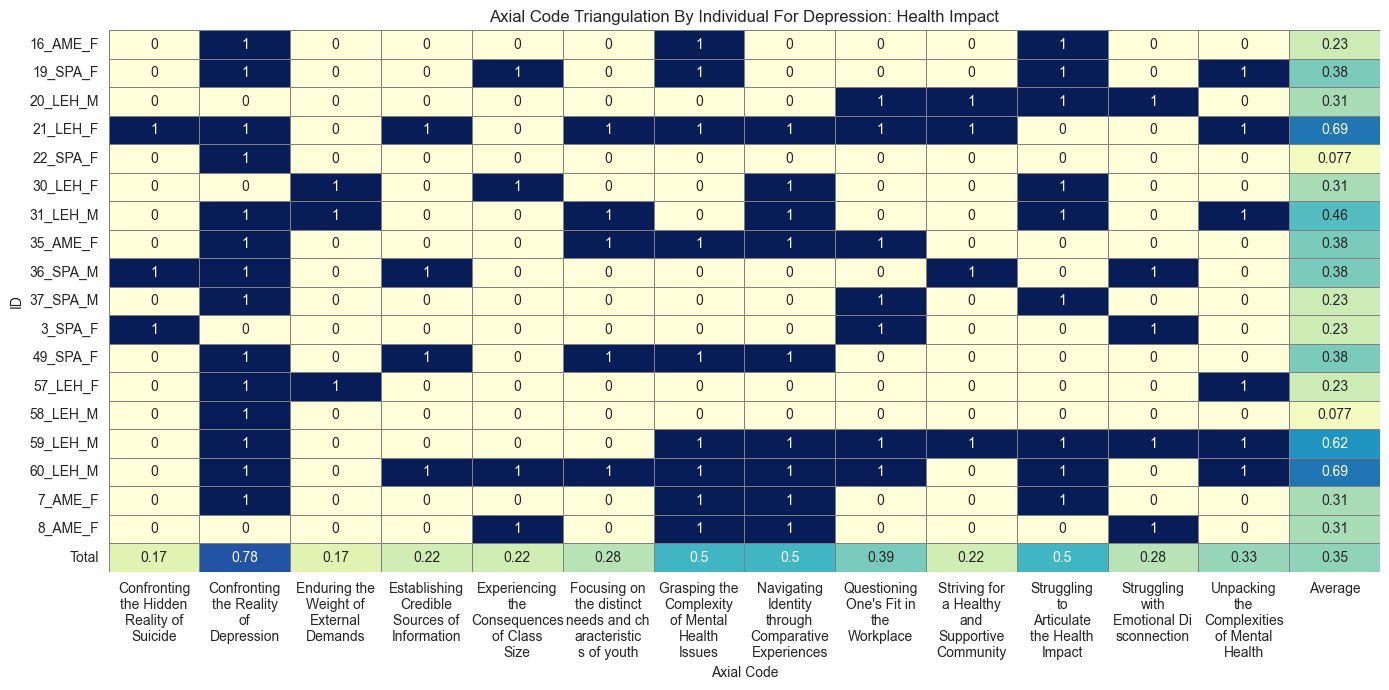

In [41]:
import textwrap

# Expand the data: each (GroupName, ID) becomes its own row
df_small = df_full_axial[
    (df_full_axial['prompt'] == 'Q10_Health Impact') &
    (df_full_axial['Q3_Health Problem'] == 'Depression') &
    (df_full_axial['cluster_id'] != -1)]

rows = []
for _, row in df_small.iterrows():
    for gid in row['cluster_orig_ids']:
        rows.append((gid, row['Axial_Code']))

# Create a DataFrame from the expanded rows
expanded_df = pd.DataFrame(rows, columns=['ID', 'Axial Code'])

# Create the final binary matrix
result_df = pd.crosstab(expanded_df['ID'], expanded_df['Axial Code'])
summary_row = result_df.mean(axis=0).to_frame().T
summary_row.index = ['Total']
full_df = pd.concat([result_df, summary_row])
full_df['Average'] = full_df.mean(axis=1)

# Wrap each column name to max 15 characters per line
wrapped_columns = ['\n'.join(textwrap.wrap(col, width=12)) for col in full_df.columns]
full_df.columns = wrapped_columns

plt.figure(figsize=(14, 7))
sns.heatmap(full_df, annot=True, cmap="YlGnBu", cbar=False, linewidths=0.5, linecolor='gray')
plt.title("Axial Code Triangulation By Individual For Depression: Health Impact")
plt.ylabel("ID")
plt.xlabel("Axial Code")
plt.xticks(rotation=0)  # now rotation is not needed since we wrapped
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


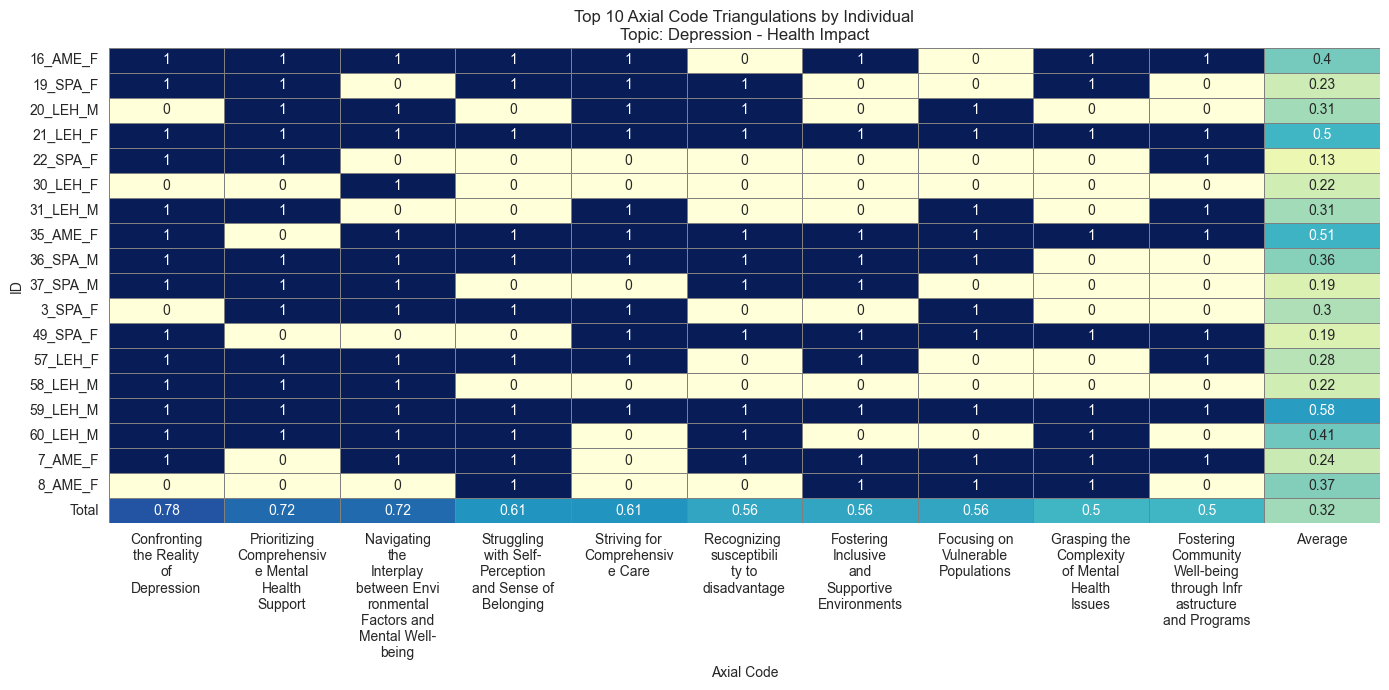

In [42]:
import textwrap
import matplotlib.pyplot as plt
import seaborn as sns

# Filter data by topic and exclude -1 cluster_ids
df_small = df_full_axial[
    (df_full_axial['Q3_Health Problem'] == 'Depression') &
    (df_full_axial['cluster_id'] != -1)
]

# Expand to rows: each (ID, Axial_Code)
rows = []
for _, row in df_small.iterrows():
    for gid in row['cluster_orig_ids']:
        rows.append((gid, row['Axial_Code']))

expanded_df = pd.DataFrame(rows, columns=['ID', 'Axial Code'])

# Binary matrix of ID x Axial Code
result_df = pd.crosstab(expanded_df['ID'], expanded_df['Axial Code'])

# Add a total row and average column
summary_row = result_df.mean(axis=0).to_frame().T
summary_row.index = ['Total']
full_df = pd.concat([result_df, summary_row])
full_df['Average'] = full_df.mean(axis=1)

# Get top 10 Axial Codes by Total row
top_10_cols = full_df.loc['Total'].drop('Average').sort_values(ascending=False).head(10).index.tolist()

# Filter full_df to include only those top columns + 'Average'
full_df = full_df[top_10_cols + ['Average']]

# Wrap column names
wrapped_columns = ['\n'.join(textwrap.wrap(col, width=12)) for col in full_df.columns]
full_df.columns = wrapped_columns

# Plot
plt.figure(figsize=(14, 7))
sns.heatmap(full_df, annot=True, cmap="YlGnBu", cbar=False, linewidths=0.5, linecolor='gray')
plt.title("Top 10 Axial Code Triangulations by Individual\nTopic: Depression - Health Impact")
plt.ylabel("ID")
plt.xlabel("Axial Code")
plt.xticks(rotation=0)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


In [ ]:
import textwrap
import matplotlib.pyplot as plt
import seaborn as sns

# Filter by topic only (not prompt), and exclude invalid clusters
df_small = df_full_axial[
    (df_full_axial['Q3_Health Problem'] == 'Depression') &
    (df_full_axial['cluster_id'] != -1)
]

# Expand to rows: (ID, Axial Code)
rows = []
for _, row in df_small.iterrows():
    for gid in row['cluster_orig_ids']:
        rows.append((gid, row['Axial_Code']))

expanded_df = pd.DataFrame(rows, columns=['ID', 'Axial Code'])

# Binary matrix
result_df = pd.crosstab(expanded_df['ID'], expanded_df['Axial Code'])

# Add average row and column
summary_row = result_df.mean(axis=0).to_frame().T
summary_row.index = ['Total']
full_df = pd.concat([result_df, summary_row])
full_df['Average'] = full_df.mean(axis=1)

# Wrap long column names
wrapped_columns = ['\n'.join(textwrap.wrap(col, width=12)) for col in full_df.columns]
full_df.columns = wrapped_columns

# Plot heatmap without x-axis labels
plt.figure(figsize=(14, 7))
sns.heatmap(full_df, annot=True, cmap="YlGnBu", cbar=False, linewidths=0.5, linecolor='gray')
plt.title("Axial Code Triangulation by Individual\nTopic: Depression")
plt.ylabel("ID")
plt.xlabel("Axial Code")
plt.xticks([], [])  # Remove x-axis labels
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


In [43]:
df_full.groupby(['prompt', 'Q3_Health Problem'])['cluster_id'].max()

prompt                   Q3_Health Problem
Q10_Health Impact        Depression           12
                         Obesity              28
Q11_At-Risk Populations  Depression           18
                         Obesity              31
Q12_Risk Factors         Depression           18
                         Obesity              29
Q13_Root Cause           Depression           14
                         Obesity              36
Q14_Community Strengths  Depression           14
                         Obesity              39
Q15_Resources            Depression           15
                         Obesity              20
Q16_Solutions            Depression           17
                         Obesity              27
Q17_Other Thoughts       Depression           10
                         Obesity              19
Name: cluster_id, dtype: int64

In [44]:
(
    df_full.groupby(['prompt', 'Q3_Health Problem'])['cluster_id']
    .max()
    .add(1)
    .groupby(level='Q3_Health Problem')
    .mean()
)

Q3_Health Problem
Depression    15.750
Obesity       29.625
Name: cluster_id, dtype: float64

In [45]:
df_full_axial[(df_full_axial['Q3_Health Problem'] == 'Obesity') & (df_full_axial['prompt'] == 'Q15_Resources')]

,prompt,Q3_Health Problem,json,clusters,clusters_size,cluster_id,center,silhouette_avg,silhouette,Code_Text_Map,Code_Id_Map,cluster_orig_ids,cluster_orig_texts,surveyed,TriangulationScore,id,model,Axial_Code
276,Q15_Resources,Obesity,"[Hospital-Based Resources for Obesity, Hospita...","[Hospital-Based Resources for Obesity, Hospita...",18,14,Healthcare Resources,0.696014,0.671430,{'Abundant Recreational Activities': ['there i...,{'Abundant Recreational Activities': ['43_EAG_...,"[0_PAY_M, 45_PRO_F, 41_PRO_F, 34_PRO_F, 28_PRO...",[Community resources at the hospital that have...,38,0.184211,Q15_Obe_14,Gemma,Accessing and Leveraging Healthcare Infrastruc...
277,Q15_Resources,Obesity,"[Hospital-Based Resources for Obesity, Hospita...","[Community Support Systems, Trails and Parks f...",20,19,Community-Based Initiatives,0.696014,0.782948,{'Abundant Recreational Activities': ['there i...,{'Abundant Recreational Activities': ['43_EAG_...,"[0_PAY_M, 55_SPR_F, 45_PRO_F, 38_PLE_M, 47_SPR...","[Community resources at the hospital, Basicall...",38,0.210526,Q15_Obe_19,Gemma,Fostering Community Engagement through Support...
278,Q15_Resources,Obesity,"[Hospital-Based Resources for Obesity, Hospita...","[Obesity-Focused Programs, Potential School-Ba...",35,7,Nutrition Education,0.696014,0.940665,{'Abundant Recreational Activities': ['there i...,{'Abundant Recreational Activities': ['43_EAG_...,"[0_PAY_M, 55_SPR_F, 45_PRO_F, 47_SPR_F, 41_PRO...","[classes that address obesity, They're buildin...",38,0.315789,Q15_Obe_7,Gemma,Implementing Holistic School-Based Approaches ...
279,Q15_Resources,Obesity,"[Hospital-Based Resources for Obesity, Hospita...","[Lack of Community Resources, Lack of Communit...",18,20,Local Community Resources,0.696014,0.392822,{'Abundant Recreational Activities': ['there i...,{'Abundant Recreational Activities': ['43_EAG_...,"[45_PRO_F, 38_PLE_M, 34_PRO_F, 10_PAY_F, 28_PR...","[I haven’t seen a community rec center., I hav...",38,0.157895,Q15_Obe_20,Gemma,Struggling with Limited Access to Community In...
280,Q15_Resources,Obesity,"[Hospital-Based Resources for Obesity, Hospita...","[Private Fitness Options, Commercial Fitness O...",16,8,Recreational Sports Opportunities,0.696014,0.510633,{'Abundant Recreational Activities': ['there i...,{'Abundant Recreational Activities': ['43_EAG_...,"[47_SPR_F, 11_EAG_F, 34_PRO_F, 15_PAY_F, 10_PA...","[There's a total fitness., There's a total fit...",38,0.157895,Q15_Obe_8,Gemma,Pursuing diverse and accessible fitness opport...
281,Q15_Resources,Obesity,"[Hospital-Based Resources for Obesity, Hospita...","[Cost Barrier, Potential for Participation, Lo...",13,1,Low Participation,0.696014,0.844227,{'Abundant Recreational Activities': ['there i...,{'Abundant Recreational Activities': ['43_EAG_...,"[9_PRO_M, 34_PRO_F, 15_PAY_F, 10_PAY_F, 28_PRO...","[It costs to use., but opportunity, people do ...",38,0.157895,Q15_Obe_1,Gemma,Confronting Accessibility Barriers
282,Q15_Resources,Obesity,"[Hospital-Based Resources for Obesity, Hospita...","[Potential Future Resource, Uncertainty of Res...",31,11,Market Accessibility,0.696014,0.853757,{'Abundant Recreational Activities': ['there i...,{'Abundant Recreational Activities': ['43_EAG_...,"[38_PLE_M, 29_ORE_M, 34_PRO_F, 10_PAY_F, 28_PR...",[They're building a brand new high school and ...,38,0.157895,Q15_Obe_11,Gemma,Navigating Resource Uncertainty and Accessibility
283,Q15_Resources,Obesity,"[Hospital-Based Resources for Obesity, Hospita...","[Uncertainty, Lack of Targeted Programs, Compe...",17,16,Tourism for Success Duplication,0.696014,-0.752165,{'Abundant Recreational Activities': ['there i...,{'Abundant Recreational Activities': ['43_EAG_...,"[38_PLE_M, 56_PAY_F, 53_SPR_F, 9_PRO_M, 34_PRO...","[I don't know., nothing targeting, ou not eat ...",38,0.236842,Q15_Obe_16,Gemma,Struggling to Replicate Success
284,Q15_Resources,Obesity,"[Hospital-Based Resources for Obesity, Hospita...","[Existing Public Spaces, Financial Barrier to ...",27,4,Out

In [46]:
# Expand the data: each (GroupName, ID) becomes its own row
df_small = df_full_axial[
    (df_full_axial['prompt'] == 'Q15_Resources') &
    (df_full_axial['Q3_Health Problem'] == 'Obesity') &
    (df_full_axial['cluster_id'] != -1)]

rows = []
for _, row in df_small.iterrows():
    for gid in row['cluster_orig_ids']:
        rows.append((gid, row['Axial_Code']))

rows

[('0_PAY_M', 'Accessing and Leveraging Healthcare Infrastructure'),
 ('45_PRO_F', 'Accessing and Leveraging Healthcare Infrastructure'),
 ('41_PRO_F', 'Accessing and Leveraging Healthcare Infrastructure'),
 ('34_PRO_F', 'Accessing and Leveraging Healthcare Infrastructure'),
 ('28_PRO_M', 'Accessing and Leveraging Healthcare Infrastructure'),
 ('1_PAY_F', 'Accessing and Leveraging Healthcare Infrastructure'),
 ('26_PRO_M', 'Accessing and Leveraging Healthcare Infrastructure'),
 ('0_PAY_M',
  'Fostering Community Engagement through Supportive Infrastructure'),
 ('55_SPR_F',
  'Fostering Community Engagement through Supportive Infrastructure'),
 ('45_PRO_F',
  'Fostering Community Engagement through Supportive Infrastructure'),
 ('38_PLE_M',
  'Fostering Community Engagement through Supportive Infrastructure'),
 ('47_SPR_F',
  'Fostering Community Engagement through Supportive Infrastructure'),
 ('12_EAG_F',
  'Fostering Community Engagement through Supportive Infrastructure'),
 ('34_PRO_

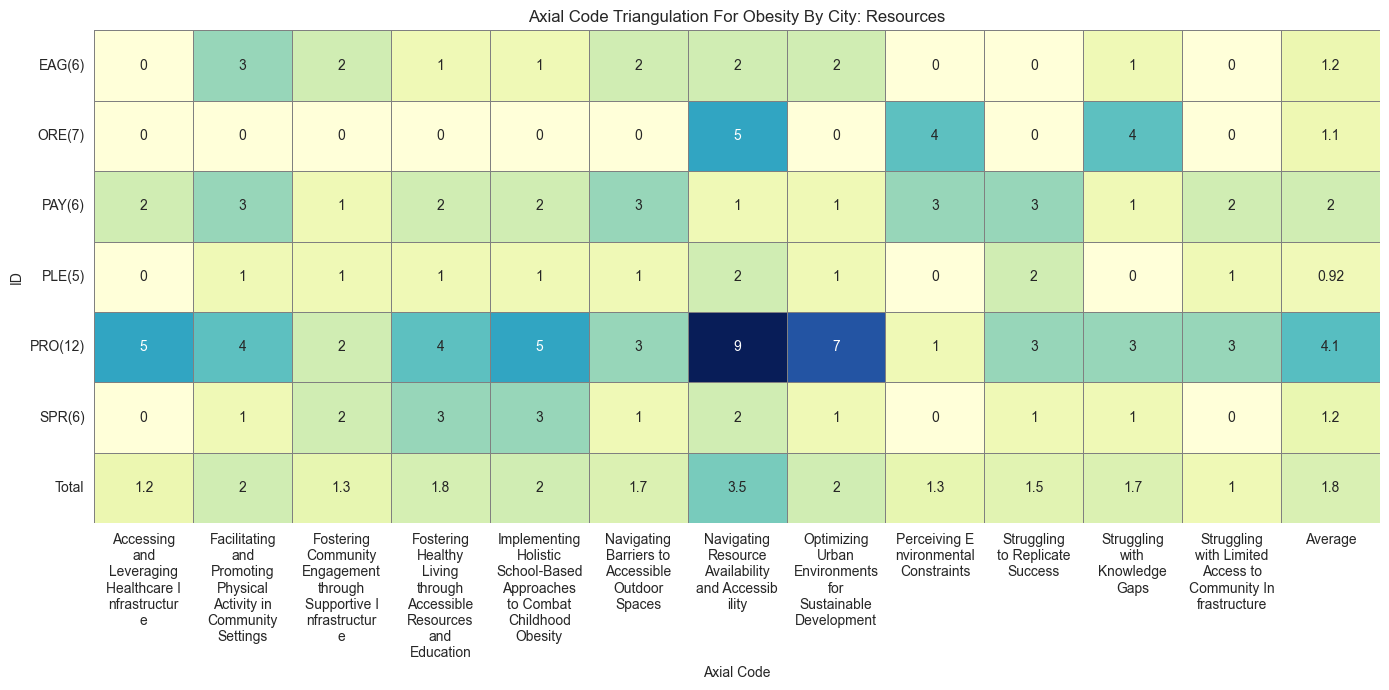

In [47]:
import textwrap
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Expand the data: each (GroupName, ID) becomes its own row
df_small = df_full_axial[
    (df_full_axial['prompt'] == 'Q15_Resources') &
    (df_full_axial['Q3_Health Problem'] == 'Obesity') &
    (df_full_axial['cluster_id'] != -1)]

rows = []
for _, row in df_small.iterrows():
    for gid in row['cluster_orig_ids']:
        rows.append((gid, row['Axial_Code']))

# Create a DataFrame from the expanded rows
expanded_df = pd.DataFrame(rows, columns=['ID', 'Axial Code'])

# Extract the 3-character group code from ID
expanded_df['Group'] = expanded_df['ID'].str.extract(r'^\d+_([A-Za-z]{3})_')

# Count unique full IDs per group
unique_ids_per_group = expanded_df.groupby('Group')['ID'].nunique().to_dict()

# Format group name with unique ID count, e.g., ABC(7)
expanded_df['GroupLabel'] = expanded_df['Group'].map(lambda g: f"{g}({unique_ids_per_group.get(g, 0)})")


# Create binary matrix using GroupLabel instead of ID
result_df = pd.crosstab(expanded_df['GroupLabel'], expanded_df['Axial Code'])


# Drop the 7 columns with the lowest triangulation score (mean value)
lowest_7 = result_df.mean().nsmallest(9).index
result_df = result_df.drop(columns=lowest_7)

# Add summary row and average
summary_row = result_df.mean(axis=0).to_frame().T
summary_row.index = ['Total']
full_df = pd.concat([result_df, summary_row])
full_df['Average'] = full_df.mean(axis=1)

# Wrap column names
wrapped_columns = ['\n'.join(textwrap.wrap(col, width=12)) for col in full_df.columns]
full_df.columns = wrapped_columns


# Plot heatmap
plt.figure(figsize=(14, 7))
sns.heatmap(full_df, annot=True, cmap="YlGnBu", cbar=False, linewidths=0.5, linecolor='gray')
plt.title("Axial Code Triangulation For Obesity By City: Resources")
plt.ylabel("ID")
plt.xlabel("Axial Code")
plt.xticks(rotation=0)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()